# Hypothesis Testing

Hypothesis testing is a critical tool in determing what the value of a parameter could be.

Our testing has two attributes:

**Null Hypothesis: $H_0$**

**Alternative Hypothesis: $H_a$**

The tests we have discussed in lecture are:

* One Population Proportion - sm.stats.proportions_ztest(phat * n, n, pnull)
* Difference in Population Proportions - sm.stats.ttest_ind(population1, population2)
* One Population Mean - sm.stats.ztest(x, value, alternative = ["larger",'Smaller'])
* Difference in Population Means - sm.stats.ztest(x1,x2)

The equation is to calculate a test statistic:

$$\frac{Best\ Estimate - Hypothesized\ Estimate}{Standard\ Error\ of\ Estimate}$$ 


In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg') # workaround, there may be a better way
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

In [2]:
df = pd.read_csv('D:/DataScience/Statistics/Nhanes_2015_2016.csv')

In [3]:
print(df.shape)
df.head()

(5735, 28)


,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [4]:
df["SMQ020x"] = df.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})
df["RIAGENDRx"] = df.RIAGENDR.replace({1: "Male", 2: "Female"})
df["DMDCITZNx"] = df.DMDCITZN.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

## Hypothesis Testing For One Proportions

- This test is used if we have specified a particular value as the null value for the proportion
- And We are looking to assess if the data are compatible with the true parameter value being equal to this specified value.
- For example, imagine that the rate of lifetime smoking in another country was known to be 40%, and we wished to assess whether the rate of lifetime smoking in the US were different from 40%.

In [5]:
p_null = .4
alpha = .05
x = (df['SMQ020x'].dropna()=='Yes')

### Method 1 

In [6]:
p_hat = x.mean()
se = np.sqrt(p_null*(1-p_null)/len(x))
p_hat,se

(0.4050655021834061, 0.00647467353462031)

In [7]:
test_stats = (p_hat-p_null)/se #calculate the test statistics 
pvalue = 2 * dist.norm.cdf(-np.abs(test_stats))
print(test_stats,pvalue)
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

0.7823563854332805 0.4340051581348052


'can not reject the null hypothesis'

### Method 2

In [8]:
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4)) # Normal approximation with estimated proportion in SE

(0.7807518954896244, 0.43494843171868214)


In [9]:
print(sm.stats.proportions_ztest(x.sum(), len(x), 0.4, prop_var=0.4)) # Normal approximation with null proportion in SE

(0.7823563854332805, 0.4340051581348052)


## Hypothesis Test for Two Proportions

-  A two-sample test of proportions is used to assess whether the proportion of individuals with some trait differs between two sub-populations.
- For example, we can compare the smoking rates between females and males.
- Below in code, we will make comaprison between males and females in age group of 20 to 25.

In [10]:
dx = df[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 20)&(dx.RIDAGEYR <= 25),:]
print(dx.shape)
dx.head()

(524, 3)


,SMQ020x,RIDAGEYR,RIAGENDRx
6,Yes,22,Male
17,No,24,Female
26,Yes,22,Male
38,No,20,Female
40,Yes,24,Male


In [11]:
dz = dx.groupby('RIAGENDRx')['SMQ020x'].agg([lambda x:np.mean(x=='Yes'),'size'])
dz.columns = ['proportion','n']
dz

,proportion,n
RIAGENDRx,,
Female,0.238971,272
Male,0.341270,252


### Method 1

In [12]:
p_comb = (dx.SMQ020x=='Yes').mean()
va = p_comb * (1-p_comb)
se = np.sqrt(va*(1/dz.n.Female + 1/dz.n.Male))
se

0.039599757248262944

In [13]:
test_stats = (dz.proportion.Female - dz.proportion.Male)/se
pvalue = 2 * dist.norm.cdf(-np.abs(test_stats))
print(test_stats,pvalue)
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

-2.5833303066279414 0.009785159057508375


'reject the null hypothesis'

### Method 2

In [14]:
dx_females = dx.loc[dx.RIAGENDRx=="Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males = dx.loc[dx.RIAGENDRx=="Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
sm.stats.ttest_ind(dx_females, dx_males) # prints test statistic, p-value, degrees of freedom

(-2.5949731446269344, 0.00972590232121254, 522.0)

## Hypothesis Test For One Population Mean

- Tests of means are similar in many ways to tests of proportions.
- Just as with proportions, for comparing means there are one and two-sample tests, z-tests and t-tests, and one-sided and two-sided tests.-
- In below example, We compare systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean is 126).

In [15]:
dx = df[['BPXSY1','RIDAGEYR','RIAGENDRx']].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 40)&(dx.RIDAGEYR<=50)&(dx.RIAGENDRx=='Male'),:] # This is among males in this age group
p_null = 120
p_hat = dx.BPXSY1.mean()
p_hat

125.86698337292161

In [16]:
test_stats,pvalue = sm.stats.ztest(dx.BPXSY1, value=120)
print(test_stats,pvalue)
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

7.469764137102597 8.033869113167905e-14


'reject the null hypothesis'

In [19]:
dx = dx.loc[(dx.RIDAGEYR >= 40)&(dx.RIDAGEYR<=50)&(dx.RIAGENDRx=='Female'),:] # This is among females in this age group
p_null = 120
p_hat = dx.BPXSY1.mean()
p_hat

120.99609375

In [20]:
test_stats,pvalue = sm.stats.ztest(dx.BPXSY1, value=120)
print(test_stats,pvalue)
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

1.4688964681916352 0.14186087274783638


'can not reject the null hypothesis'

## Hypothesis Testing For Population Means 
- In the cell below, we carry out a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60. 

- There are a number of different variants on the two-sample t-test.
- Two often-encountered variants are the t-test carried out using the t-distribution, 
- the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test. 
- Below we display results from both these testing approaches.  
- When the sample size is large, the difference between the t-test and z-test is very small. 

In [22]:
dx = df[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]

In [23]:
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]

In [ ]:
print(bpx_female.mean(), bpx_male.mean()) # prints female mean, male mean
test_stats,pvalue = sm.stats.ztest(bpx_female, bpx_male)

In [26]:
print(test_stats,pvalue) # prints test statistic, p-value
print(sm.stats.ttest_ind(bpx_female, bpx_male)) # prints test statistic, p-value, degrees of freedom
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

1.4688964681916352 0.14186087274783638
(-1.105435895556249, 0.26925004137768577, 952.0)


'can not reject the null hypothesis'

- Another important aspect of two-sample mean testing is "heteroscedasticity"
- It means that the variances within the two groups being compared may be different.  
- While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statistically significant). 
- In the NHANES data, we see that there are moderate differences between the amount of variation in BMI for females and for males, looking within 10-year age bands. 
- In every age band, females having greater variation than males.
- Link : http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html

In [31]:
dx = df[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()
df["agegrp"] = pd.cut(df.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
df.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack()

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


- The standard error of the mean difference (e.g. mean female blood pressure minus mean male blood pressure) can be estimated in at least two different ways. 
- In the statsmodels library, these approaches are referred to as the "pooled" and the "unequal" approach to estimating the variance. 
- If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches.  
- Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two methods are quite similar.  
- Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men.  The results printed in each row of output are the test-statistic and p-value.

In [33]:
for k, v in df.groupby("agegrp"):
    #print(k,v)
    bmi_female = v.loc[v.RIAGENDRx=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    bmi_male = v.loc[v.RIAGENDRx=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    print(k)
    print("pooled: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='pooled'))
    print("unequal:", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='unequal'))
    print()

(18, 30]
pooled:  (1.7026932933643388, 0.08862548061449649)
unequal: (1.7174610823927268, 0.08589495934713022)

(30, 40]
pooled:  (1.4378280405644843, 0.15048285114648385)
unequal: (1.4437869620833423, 0.14879891057892675)

(40, 50]
pooled:  (2.893376115807011, 0.003811246059501445)
unequal: (2.9678691663536654, 0.0029987194174036034)

(50, 60]
pooled:  (3.362108779981367, 0.0007734964571391746)
unequal: (3.375494390173923, 0.0007368319423226574)

(60, 70]
pooled:  (3.617240144243268, 0.00029776102103194453)
unequal: (3.6284830945445523, 0.00028509141471493076)

(70, 80]
pooled:  (2.926729252512258, 0.0034254694144858636)
unequal: (2.937779886769224, 0.003305716331519299)



### Paired Test

- A common situation in applied research is to measure the same quantity multiple times on each unit of analysis. 
- For example, in NHANES, systolic blood pressure is measured at least two times (sometimes there is a third measurement) on each subject. 
- Although the measurements are repeated, there is no guarantee that the mean is the same each time, 
- A paired test is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

- A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero. 
- Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement.  
- While this difference is not large, it is strongly statistically significant.  That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [35]:
dx = df[["BPXSY1", "BPXSY2"]].dropna()
db = dx.BPXSY1 - dx.BPXSY2
print(db.mean())
test_stats,pvalue = sm.stats.ztest(db)
print(test_stats,pvalue)
'reject the null hypothesis' if pvalue<alpha else 'can not reject the null hypothesis'

0.6749860309182343
9.800634425497911 1.1188070930963587e-22


'reject the null hypothesis'

- To probe this effect further, we can divide the population into 10 year wide age bands and also stratify by gender, then carry out the paired t-test within each of the resulting 12 strata.
- We see that the second systolic blood pressure measurement is always lower on average than the first.  


In [39]:
dx = df[["RIAGENDRx", "BPXSY1", "BPXSY2", "RIDAGEYR"]].dropna()
dx["agegrp"] = pd.cut(dx.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
for k, g in dx.groupby(["RIAGENDRx", "agegrp"]):
    db = g.BPXSY1 - g.BPXSY2
    # print stratum definition, mean difference, sample size, test statistic, p-value
    test_stats,pvalue = sm.stats.ztest(db.values, value=0)
    print(k, db.mean(), db.size, test_stats,pvalue)
    print('--reject the null hypothesis--') if pvalue<alpha else print('--can not reject the null hypothesis--')

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 569 0.7612107360791227 0.4465312067051751
--can not reject the null hypothesis--
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 426 3.307398751951031 0.0009416674523368051
--reject the null hypothesis--
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 469 2.6040611621024654 0.009212631487347644
--reject the null hypothesis--
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 445 3.1023718750881724 0.001919766301204196
--reject the null hypothesis--
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 396 3.1024528501809625 0.0019192411825181255
--reject the null hypothesis--
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 390 5.141706875154317 2.722536503552981e-07
--reject the null hypothesis--
('Male', Interval(18, 30, closed='right')) 0.00390625 512 0.01959622841647691 0.9843654725443948
--can not reject the null hypothesis--
('Male', Interval(30, 

- The difference is larger for older people and for males.  The difference is statistically significant for females over 30, and for males over 60.   

## Power and sample size for hypothesis tests

- Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data.
- Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test. 
- For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement have different means, restricting to people between 50 and 60 years of age.

- The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample.
- This process is repeated 500 times for each sample size.  
- We report the fraction of these 500 trials where the p-value was smaller than 0.05.
- A higher fraction of trials where p<0.05 implies that it is easier to detect a difference between the first and second blood pressure measurements.
- We see that this proportion (called "statistical power") is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800. 
- Note that all of these subsamples are drawn from the same parent population,
- so there is no change from subsample to subsample in terms of whether the means are truly different.  The only thing that changes is our evidence that the difference is real. 
When the sample size is small, we rarely amass such evidence.
- Link : https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [41]:
all_p = []
dy = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
for n in 100, 200, 400, 800:
    pv = []
    for i in range(500):
        dz = dy.sample(n)
        db = dz.BPXSY1 - dz.BPXSY2
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    pv = np.asarray(pv)
    all_p.append(pv)
    print((pv <= 0.05).mean())

0.248
0.414
0.702
0.998


- In the simulation code above, we saved all the p-values to the array named `all_p` so we can consider them further here. 
- The histogram below shows the distribution of p-values for 500 subsamples of data of size 100. 
- We see that there are more smaller p-values than larger ones, but not to a dramatic degree.
- Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

Text(0.5, 0, 'P-Value')

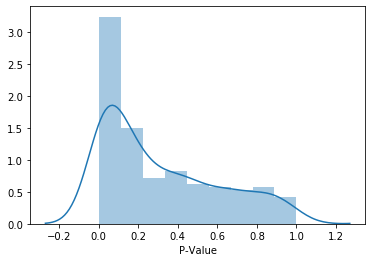

In [49]:
ht = sns.distplot(all_p[0])
ht.set_xlabel('P-Value')

- Next we inspect the distribution of p-values for subsamples of size 400. 
- We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points. 
- If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

Text(0.5, 0, 'P-Value')

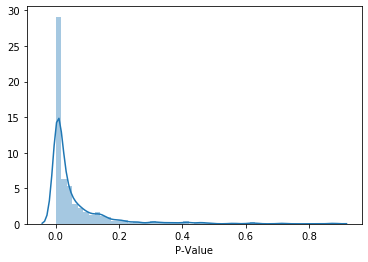

In [50]:
ht = sns.distplot(all_p[2])
ht.set_xlabel('P-Value')